## 1. Introduction 
* 이전 시간에는 EDA를 통해서 Pathology data의 label과 image에 대해서 살펴보았습니다. 
* 또한 data를 전처리 과정을 통해서 미리 patch로 잘라보는 과정까지 거쳤는데요 
* 본격적으로 이번 실습시간에서는 학습까지 해보는 시간을 가져보도록 하겠습니다. 
* 기본 baseline의 학습에 대해서 알아보고 성능의 개선의 tricks들까지 알아보도록 하겠습니다.

In [1]:
## Path관련 library
from pathlib import Path

## WSI관련 library
import openslide
import cv2
import seaborn as sns

## etc
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

## deep learnin model 관련
import torch 

import random
import os
import skimage
import sys


from tqdm.notebook import tqdm
from sklearn.metrics import cohen_kappa_score ## metric
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class cfg: 
    img_size = 128
    sz = 128
    bs = 2
    n_tiles = 36 #number of tiles per image
    # Location of the training images
    BASE_PATH = '../input/prostate-cancer-grade-assessment'
    # image and mask directories
    data_dir = f'{BASE_PATH}/train_images'
    mask_dir = f'{BASE_PATH}/train_label_masks'
    tile_img_path = '/kaggle/input/panda-16x128x128-tiles-data/train/'
    tile_mask_path = '/kaggle/input/panda-16x128x128-tiles-data/masks/'
    make_patch = False
    do_train = True
    do_infer = True
    nfolds = 6
    fold = 0
    out_cls = 5
    seed=2024
    lr = 3e-4
    warmup_epo = 1
    n_epochs = 10

In [3]:
# Location of training labels
train = pd.read_csv(f'{cfg.BASE_PATH}/train.csv')
train.head(2)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0


In [4]:
train['img_path'] = train['image_id'].apply(lambda x : Path(cfg.data_dir)/ (x+'.tiff'))
train['mask_path'] = train['image_id'].apply(lambda x : Path(cfg.mask_dir)/ (x+'.tiff'))
train.head(2)

,image_id,data_provider,isup_grade,gleason_score,img_path,mask_path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...,../input/prostate-cancer-grade-assessment/trai...
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...,../input/prostate-cancer-grade-assessment/trai...


# 2. Make dataset & Data loader
* pathology처럼 큰 이미지의 경우 patch로 잘라서 학습을 하는 과정을 거친다. 
* 따로 저장을 하여서 사용하는 방법도 있으며 바로 iteration마다 patch를 잘라서 학습을 하는 방법이 있다.
* `kaggle`에서는 side의 bar에서 이전에 저장헀던 데이터를 쉽게 불러오고 이미 작업을 하였던 데이터에 대해서 쉽게 불러올 수 있습니다.

#### 2.1 Splite kfold
* 학습을 하기 위해서는 내부 validation과 traind을 fold를 나뉘어서 학습을 해야된다.

In [5]:
from sklearn.model_selection import StratifiedKFold

df = train.set_index('image_id')
files = sorted(set([str(p.name)[:32] for p in list(Path(cfg.tile_img_path).glob('*.png'))]))
df = df.loc[files]
df = df.reset_index()


splits = StratifiedKFold(n_splits=cfg.nfolds, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(int)
for i in range(cfg.nfolds): folds_splits[splits[i][1]] = i
df['split'] = folds_splits

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [40]:
DEBUG = False 
cfg.n_epochs = 1 if DEBUG else 30
df = df.sample(100).reset_index(drop=True) if DEBUG else df


In [41]:
df.head(2)

,image_id,data_provider,isup_grade,gleason_score,img_path,mask_path,split
0,55321af8983669e2145d69e518fbc54c,radboud,4,3+5,../input/prostate-cancer-grade-assessment/trai...,../input/prostate-cancer-grade-assessment/trai...,3
1,7ff53392c1d6293b7f90e4dc139977c0,karolinska,1,3+3,../input/prostate-cancer-grade-assessment/trai...,../input/prostate-cancer-grade-assessment/trai...,1


In [42]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(cfg.seed)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
import albumentations as A

### 2.2 Normalize value 추출 & Augmentation 
* 모든 이미지의 mean, std에 대해서 계산을 하면 generalize가 잘 되어지는 특징이 있다. 
* 이번 실험에서는 따로 계산은 하지 않고 정해져있는 mean, std를 사용하도록 하겠다.
* dataset이 만들어지기 이전에 augmentation에 대해서 설정하도록 하겠습니다. 
* 또한 Augmentation의 경우 2D image에서 많이 사용되어지는 albumentation을 적용해보록 하겠습니다. 

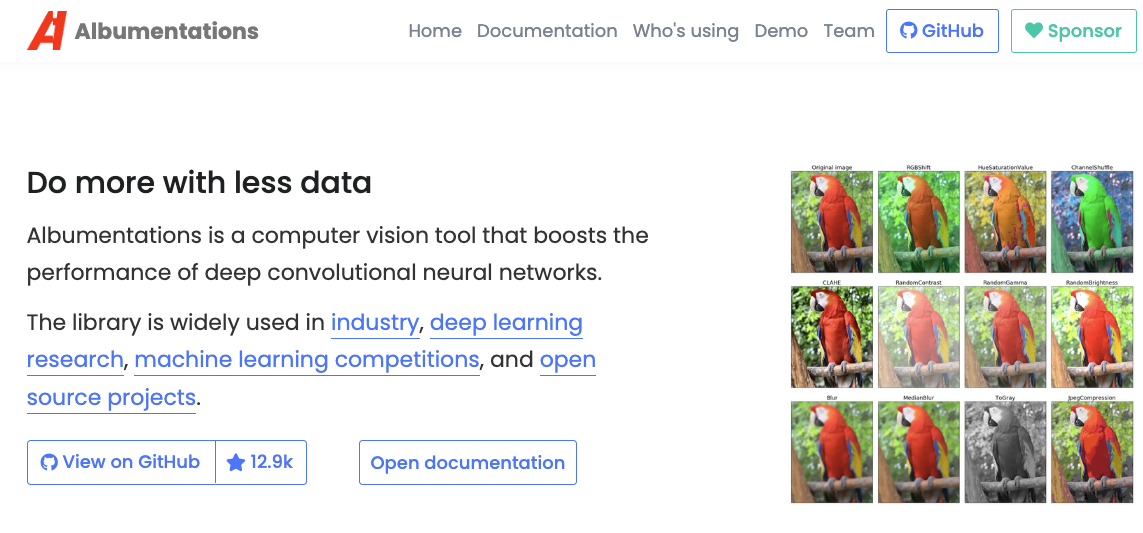

In [44]:
# 이전 실습시간에 EDA를 통하여 구함
mean = np.array([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = np.array([0.36357649, 0.49984502, 0.40477625])


transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
])
transforms_val = A.Compose([])


## 2.5 Patch 단위 dataset 불러오기
* 일반적으로 WSI를 불러오면 학습에 오랜 시간이 걸리기 때문에 memory의 활용을 위해서 이미 Tile이 되어진 데이터를 활용하여 적용을 해보자.
* dataset을 만들면 데이터가 올바르게 들어가는지 확인해보는건 필수입니다. 
* 실질적으로 데이터가 잘 들어가는지 확인해보고 augmentation & label도 잘들어가는지 확인해봅시다

In [45]:
class TilePANDADataset(Dataset):
    def __init__(self,
                 df,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                 n_tiles=16
                ):

        self.df = df.reset_index(drop=True)
        self.tile_mode = tile_mode
        self.transform = transform
        self.n_tiles = n_tiles
        self.image_size = cfg.sz
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        tiff_file = str(row.img_path)
        
        tile_img_path = list(Path(cfg.tile_img_path).glob(f'{row.image_id}*.png')).copy()
        tile_mask_path= list(Path(cfg.tile_mask_path).glob(f'{row.image_id}*.png'))
#         row['tile_img_path'] = row['image_id'].apply(lambda x : )
#         row['tile_mask_path'] = row['image_id'].apply(lambda x : list(Path(cfg.tile_mask_path).glob(f'{x}*.png')))
        idxes = np.random.choice(list(range(len(tile_img_path))), self.n_tiles, replace=False)
        img_path_list = np.array(tile_img_path)[idxes]
        mask_path_list = np.array(tile_mask_path)[idxes]
        
        tiles = []
        for img_path, mask_path in zip(img_path_list, mask_path_list):
            patch = cv2.imread(str(img_path))
            tiles.append(patch)
                
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((patch.shape[-2] * n_row_tiles, patch.shape[-2] * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * self.image_size
                w1 = w * self.image_size
                images[h1:h1+cfg.sz, w1:w1+cfg.sz] = this_img


        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [46]:
dataset_show = TilePANDADataset(df, cfg.n_tiles,transform=transforms_train)
idx = np.random.randint(0, len(dataset_show))
img, label = dataset_show[0]

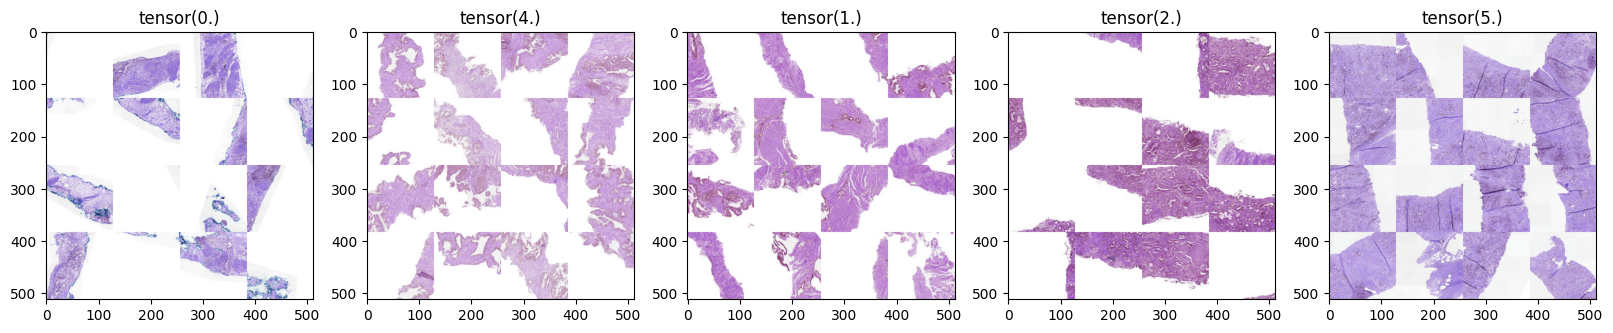

In [58]:
dataset_show = TilePANDADataset(df, cfg.n_tiles,transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
f, axarr = plt.subplots(1,5)
for p in range(5):
    idx = np.random.randint(0, len(dataset_show))
    img, label = dataset_show[idx]
    axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
    axarr[p].set_title(str(sum(label)))

In [57]:
# dataset_show = TilePANDADataset(df, cfg.img_size, cfg.n_tiles, 0, transform=transforms_train)
# from pylab import rcParams
# rcParams['figure.figsize'] = 20,10
# for i in range(2):
#     f, axarr = plt.subplots(1,5)
#     for p in range(5):
#         idx = np.random.randint(0, len(dataset_show))
#         img, label = dataset_show[idx]
#         axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
#         axarr[p].set_title(str(sum(label)))

TypeError: TilePANDADataset.__init__() got multiple values for argument 'transform'

In [49]:
img.shape

torch.Size([3, 768, 768])

위의 방법처럼 이제 Patch로 나뉘어짐을도 같이 확인 완료!!!

## 3. Model 구성 
* 학습에 가장 기본이 되어지는 모델에 대해서 만들어보자. 
* 이번시간에는 Resnet이 아니라 efficent b0로 사용해보고 pretrained wegith를 끼워넣어보자
* 모델을 불러오기 위해서 `timm`이라는 라이브러리를 사용한다. 

In [50]:
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [51]:
from efficientnet_pytorch import model as enet


In [52]:
class Model(nn.Module):
    def __init__(self, backbone, out_dim):
        super(Model, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
    

## 4.Train & validation
* Train와 validation의 경우 상대적으로 간편하다. 
* epoch마다 학습 logging과 loss backprob에 대해서만 설정해놓

In [53]:
criterion = nn.BCEWithLogitsLoss()
loss_func = criterion

def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for data, target in bar:
        
        data, target = data.cuda(), target.cuda() 
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss = loss.detach().cpu().numpy()
        train_loss.append(loss)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss, smooth_loss))
        
        del data, target
        
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss, logit, predict, targets = [], [], [], []
    
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.cuda(), target.cuda()
            logits = model(data)
            loss = criterion(logits, target)
            pred = logits.sigmoid().sum(1).detach().round()
            logit.append(logits)
            predict.append(pred)
            targets.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
            
            del data, target
        val_loss = np.mean(val_loss)

    logit = torch.cat(logit).cpu().numpy()
    predict = torch.cat(predict).cpu().numpy()
    targets = torch.cat(targets).cpu().numpy()
    acc = (predict == targets).mean() * 100.
    
    # evaluation
    qwk = cohen_kappa_score(predict, targets, weights='quadratic')
    qwk_k = cohen_kappa_score(predict[valid_df['data_provider'] == 'karolinska'], valid_df[valid_df['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(predict[valid_df['data_provider'] == 'radboud'], valid_df[valid_df['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

## 5. Dataloader , model, optimizer setting
* 이제 앞전에 모았던 모든 객체를 불러와서 만들어보자. 

In [54]:

train_df = df.query(f'split!={cfg.fold}')
valid_df = df.query(f'split=={cfg.fold}')

# dataset_train = PANDADataset(train_df, cfg.img_size, cfg.n_tiles, transform=transforms_train)
# dataset_valid = PANDADataset(valid_df, cfg.img_size, cfg.n_tiles, transform=transforms_val)

dataset_train = TilePANDADataset(train_df, cfg.n_tiles,transform=transforms_train)
dataset_valid = TilePANDADataset(valid_df, cfg.n_tiles,transform=transforms_train)


train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=cfg.bs, sampler=RandomSampler(dataset_train), num_workers=4)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=cfg.bs, sampler=SequentialSampler(dataset_valid), num_workers=4)

model = Model('efficientnet-b0', out_dim=cfg.out_cls)
model = model.cuda()



In [55]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.Adam(model.parameters(), lr=cfg.lr/10)
scheduler = OneCycleLR(optimizer, max_lr=cfg.lr*10, \
                              epochs=cfg.n_epochs, steps_per_epoch=len(train_loader))

### 6. Start !!! Training & Validation
* 이전에 설정했던 모든 방식들을 바탕으로 학습을 해보자.

In [56]:
if cfg.do_train : 
    import time
    from tqdm.notebook import tqdm
    qwk_max = 0.
    best_file = f'test_best_fold{cfg.fold}.pth'
    for epoch in range(1, cfg.n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler.step(epoch-1)

        train_loss = train_epoch(train_loader, optimizer)
        val_loss, acc, qwk = val_epoch(valid_loader)

        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
        print(content)

        if qwk > qwk_max:
            print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
            torch.save(model.state_dict(), best_file)
            qwk_max = qwk

    torch.save(model.state_dict(), os.path.join(f'{epoch}_final_fold{cfg.fold}.pth'))

Thu Dec 21 12:17:15 2023 Epoch: 1


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:17:35 2023 Epoch 1, lr: 0.0001200, train loss: 0.65875, val loss: 0.69099, acc: 0.00000, qwk: 0.00000
Thu Dec 21 12:17:35 2023 Epoch: 2


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:17:55 2023 Epoch 2, lr: 0.0001200, train loss: 0.60218, val loss: 0.68414, acc: 0.00000, qwk: 0.00000
Thu Dec 21 12:17:55 2023 Epoch: 3


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:18:14 2023 Epoch 3, lr: 0.0001202, train loss: 0.58521, val loss: 0.67028, acc: 0.00000, qwk: 0.00000
Thu Dec 21 12:18:14 2023 Epoch: 4


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:18:34 2023 Epoch 4, lr: 0.0001204, train loss: 0.58826, val loss: 0.65294, acc: 0.00000, qwk: 0.00000
Thu Dec 21 12:18:34 2023 Epoch: 5


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:18:54 2023 Epoch 5, lr: 0.0001208, train loss: 0.60176, val loss: 0.64194, acc: 12.50000, qwk: 0.00000
Thu Dec 21 12:18:54 2023 Epoch: 6


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:19:14 2023 Epoch 6, lr: 0.0001212, train loss: 0.60256, val loss: 0.62874, acc: 12.50000, qwk: 0.00000
Thu Dec 21 12:19:14 2023 Epoch: 7


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:19:34 2023 Epoch 7, lr: 0.0001218, train loss: 0.58570, val loss: 0.60473, acc: 0.00000, qwk: 0.00000
Thu Dec 21 12:19:34 2023 Epoch: 8


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

qwk 0.0 qwk_k 0.0 qwk_r 0.0
Thu Dec 21 12:19:53 2023 Epoch 8, lr: 0.0001224, train loss: 0.58637, val loss: 0.62356, acc: 12.50000, qwk: 0.00000
Thu Dec 21 12:19:53 2023 Epoch: 9


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/42 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def load_models(model_files):
    models = []
    for model_f in model_files:
        model_f = os.path.join('/kaggle/input/panda-enet-b1-model', model_f)
        backbone = 'efficientnet-b0'
        model = enetv2(backbone, out_dim=5)
        model.load_state_dict(torch.load(model_f, map_location=lambda storage, loc: storage), strict=True)
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models

In [ ]:
if cfg.do_infer : 
    
    model_files = [
        'enet_8ep_fold0.pth'
    ]

    models = load_models(model_files)

    dataset_test = PANDADataset(valid_df, cfg.img_size, cfg.n_tiles, transform=transforms_val, use_mask=False)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=cfg.bs, sampler=SequentialSampler(dataset_test), num_workers=4)
    